## Libraries and options

In [2]:
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By

from bs4 import BeautifulSoup
import pandas as pd
import time 
import os

import regex as re
import requests

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import spacy
from collections import Counter

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
import numpy as np

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 300)

ModuleNotFoundError: No module named 'xgboost'

## Scraping

In [274]:
#Website and path to chrome driver#
website = 'https://www.conseil-etat.fr/arianeweb/#/recherche'
path = '/Users/el/Downloads/chromedriver-mac-arm64/chromedriver' #To be modified with the path of chromedriver


In [275]:
#Options#

chromeOptions = webdriver.ChromeOptions()
prefs = {"download.default_directory" : "/Users/el/Library/CloudStorage/OneDrive-Personal/Project Text Mining/html"} #Download folder#
chromeOptions.add_experimental_option("prefs",prefs)
driver = webdriver.Chrome(path,options=chromeOptions)
driver.get(website)



In [272]:
#Search bar (to put the "L.64")
textarea = driver.find_element(By.XPATH, "//textarea[@ng-model='search.currentSearch.query']")
textarea.clear()  # Clear any pre-filled text
textarea.send_keys('"L.64"')  # Key word to search

In [273]:
# looking at the .html in a browser > Inspect, we see the relevant checkbow has an
# attribute 'ng-change' with value 'sources.selectSource('AW_DCE')'
att = "sources.selectSource('AW_DCE')"
att2 = "sources.selectSource('AW_DCA')"

el = driver.find_element(By.XPATH, r'.//*[@ng-change="' + att + '"]')
el.click() 

el2 = driver.find_element(By.XPATH, r'.//*[@ng-change="' + att2 + '"]')
el2.click() 

# Click the search button
button = driver.find_element(By.XPATH, ".//button[@class='btn btn-primary']")
button.click()


In [ ]:
#Open and download all cases into the download folder#
#Open the first case and click next to surf through all cases#


soup = BeautifulSoup(driver.page_source)  # We recreate a soup, now that the page source
table = soup.find_all("table")[-1]  # Collect tables from the page; there are two of them
# in the page source (and find_all returns a list), and we are interested in the last one.

df = pd.read_html(str(table))[-1]  
# Convert the table in a panda
# dataframe, with each row storing data about one decision.

for index, row in df.iloc[:1].iterrows():  # For each row, we'll make the browser click on the element
    # and collect the judgment
    num = re.search(r"\d+", row["Numéro d'affaire"]).group()  
    row_el = driver.find_element(By.XPATH, ".//td[contains(text(), '" + num + "')]")
    # With that num, we look for the relevant element in browser
    row_el.click()  # load page with judgment
    # time.sleep(1) 
    driver.switch_to.window(driver.window_handles[-1])
    ## Switch the driver's focus to the window you just opened, with method "switch to",
    # and argument the relevant window from the list of window_handles
    # (latest loaded window will be -1)

while True:
    # Attempt to find the "next page" button
    try:
        next_page = driver.find_element(By.CSS_SELECTOR, "button[title='document suivant']")
        if next_page.get_attribute('disabled') == 'true' or not next_page.is_displayed():
            # If the "next page" button is disabled or not displayed, break the loop
            break
        else:
            # If the button is active, click it to go to the next page
            next_page.click()
            time.sleep(1)  # Adjust time as necessary for page loading

        # Logic here for processing the current page
        ave_el = driver.find_element(By.CSS_SELECTOR, "button[title='enregistre le document']")
        ave_el.click() 
        # Add any other actions you need to perform on each page

    except NoSuchElementException:
        # If the "next page" button cannot be found at all, assume end of pages
        break


## Create data frame

In [256]:
# Create dictionnary of months in french to be converted in number
months_fr_to_en = {
    'janvier': '01', 'février': '02', 'mars': '03', 'avril': '04',
    'mai': '05', 'juin': '06', 'juillet': '07', 'août': '08',
    'septembre': '09', 'octobre': '10', 'novembre': '11', 'décembre': '12'
}

# Regex pattern to match French date format "Lecture du DD Month YYYY", ignoring case and day of the week
date_pattern = re.compile(r'Lecture du\s+(?:\w+\s+)?(\d+)\s+(\w+)\s+(\d{4})', re.IGNORECASE)

# Path to the folder containing your HTML files
directory_path = '/Users/el/Library/CloudStorage/OneDrive-Personal/Project Text Mining/html'

# Initialize a list to hold the data
data = []

# Regex patterns to identify the participant, the body, and the decision text starting with "Article 1 :"
participant_pattern = re.compile(r'(.*?)REPUBLIQUE FRANCAISE.*?AU NOM DU PEUPLE FRANCAIS', re.DOTALL | re.IGNORECASE)
body_pattern = re.compile(r'REPUBLIQUE FRANCAISE.*?AU NOM DU PEUPLE FRANCAIS(.*?)(?=Article 1(?:er)?[\s:,.])', re.DOTALL | re.IGNORECASE)
decision_pattern = re.compile(r'(Article 1(?:er)?[\s:,.].*)', re.DOTALL | re.IGNORECASE)

# Function to determine the outcome with refined logic
def determine_outcome(decision_text):
    # Split the decision text into sentences for a detailed analysis.
    sentences = re.split(r'(?<=[.!?])\s+', decision_text)
    
    for sentence in sentences:
        # Check for "rejeté" or "rejetée" in the sentence.
        if re.search(r'rejeté|rejetée', sentence, re.IGNORECASE):
            # If "ministre" is in the same sentence, outcome is "Contribuable".
            if 'ministre' in sentence.lower():
                return "Contribuable"
            # If "ministre" is not mentioned, outcome is "Administration".
            else:
                return "Administration"
        # Check for other keywords indicating a "Contribuable" outcome.
        elif re.search(r'annulé|annulée|admises?|admis', sentence, re.IGNORECASE):
            return "Contribuable"
    
    # If none of the conditions are met, the outcome is "Indéterminé".
    return "Indéterminé"


# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.html'):
        file_path = os.path.join(directory_path, filename)
        
        with open(file_path, 'r', encoding='ISO-8859-1') as file:
            soup = BeautifulSoup(file.read(), 'html.parser')
            text_content = soup.get_text(" ", strip=True)
            
            participant_text = participant_pattern.search(text_content).group(1).strip() if participant_pattern.search(text_content) else "Not found"
            body_text = body_pattern.search(text_content).group(1).strip() if body_pattern.search(text_content) else "Not found"
            decision_text = decision_pattern.search(text_content).group(1).strip() if decision_pattern.search(text_content) else "Not found"
            
            date_match = date_pattern.search(participant_text)
            formatted_date = "Not found"
            if date_match:
                day, month_text, year = date_match.groups()
                month = months_fr_to_en.get(month_text.lower(), '00')
                formatted_date = f"{day}/{month}/{year}"
            
            case_type = "CAA" if any(c.isalpha() for c in os.path.splitext(filename)[0]) else "Decision"
            outcome = determine_outcome(decision_text)
            
            data.append([filename.split('.')[0], formatted_date, case_type, participant_text, body_text, decision_text, outcome])

df = pd.DataFrame(data, columns=['Case Number', 'Date', 'Case', 'Participant Text', 'Body Text', 'Decision Text', 'Outcome'])

# Add the "Avocat" column
df['Avocat'] = df['Participant Text'].apply(lambda x: "Yes" if "avocat" in x.lower() else "No")

# Display the DataFrame
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 300)
df

,Case Number,Date,Case,Participant Text,Body Text,Decision Text,Outcome,Avocat
0,313139,8/10/2010,Decision,"Conseil d'État N° 313139 ECLI:FR:CESSR:2010:313139.20101008 Mentionné au tables du recueil Lebon 8ème et 3ème sous-sections réunies M. Arrighi de Casanova, président M. Patrick Quinqueton, rapporteur M. Olléon Laurent, rapporteur public SCP ORTSCHEIDT, avocats Lecture du vendredi 8 octobre 2010","Vu le pourvoi, enregistré le 8 février 2008 au secrétariat du contentieux du Conseil d'Etat, présenté par le MINISTRE DU BUDGET, DES COMPTES PUBLICS ET DE LA FONCTION PUBLIQUE ; le ministre demande au Conseil d'Etat d'annuler l'arrêt du 11 décembre 2007 par lequel, faisant droit à la requête de ...","Article 1er : L'arrêt de la cour administrative d'appel de Douai du 11 décembre 2007 est annulé. Article 2 : M. et Mme Bauchart sont déchargés des cotisations supplémentaires d'impôt sur le revenu et de contributions sociales auxquelles ils sont restés assujettis au titre de l'année 1998, ainsi ...",Contribuable,Yes
1,420824,20/09/2019,Decision,"Conseil d'État N° 420824 ECLI:FR:CECHR:2019:420824.20190920 Inédit au recueil Lebon 8ème - 3ème chambres réunies M. Laurent Domingo, rapporteur M. Romain Victor, rapporteur public SCP MATUCHANSKY, POUPOT, VALDELIEVRE, avocats Lecture du vendredi 20 septembre 2019","Vu la procédure suivante : La société anonyme (SA) Crédit Agricole a demandé au tribunal administratif de Montreuil de prononcer la décharge des cotisations supplémentaires d'impôt sur les sociétés auxquelles elle a été assujettie au titre des exercices clos en 2006 et 2007, et des pénalités cor...",Article 1er : Le pourvoi du ministre de l'action et des comptes publics est rejeté. Article 2 : L'Etat versera une somme de 3 000 euros à la société Crédit Agricole au titre de l'article L. 761-1 du code de justice administrative. Article 3 : La présente décision sera notifiée au ministre de l'a...,Contribuable,Yes
2,472587,8/12/2023,Decision,"Conseil d'État N° 472587 ECLI:FR:CECHR:2023:472587.20231208 Publié au recueil Lebon 3ème, 8ème, 9ème et 10ème chambres réunies M. Pierre Collin, président M. Vincent Mahé, rapporteur M. Romain Victor, rapporteur public Lecture du vendredi 8 décembre 2023","Vu la procédure suivante : Par une requête, un mémoire complémentaire, un mémoire en réplique et un mémoire en duplique, enregistrés les 30 mars, 26 avril, 7 juillet et 9 août 2023 au secrétariat du contentieux du Conseil d'Etat, la Fédération bancaire française demande au Conseil d'Etat : 1°) d...","Article 1er : La dernière phrase du paragraphe 1 et le paragraphe 5 des commentaires administratifs publiés le 15 février 2023 au bulletin officiel des finances publiques-Impôts sous la référence BOI-RPPM-RCM-30-30-10-10, ainsi que les commentaires administratifs publiés sous les références BOI-...",Contribuable,No
3,89bx00231,2/07/1990,CAA,"Cour administrative d'appel de Bordeaux N° 89BX00231 Mentionné au tables du recueil Lebon 1E CHAMBRE M. Tourdias, président M. Piot, rapporteur M. de Malafosse, commissaire du gouvernement Lecture du 2 juillet 1990","Vu la décision en date du 1er décembre 1988, enregistrée au greffe de la cour le 15 décembre 1988, par laquelle le président de la 7ème sous-section de la Section du contentieux du Conseil d'Etat a transmis à la cour, en application de l'article 17 du décret n° 88-906 du 2 septembre 1988, la req...",Not found,Indéterminé,No
4,359900,23/07/2014,Decision,"Conseil d'État N° 359900 ECLI:FR:CESJS:2014:359900.20140723 Inédit au recueil Lebon 9ème sous-section jugeant seule Mme Séverine Larere, rapporteur M. Frédéric Aladjidi, rapporteur public SCP PIWNICA, MOLINIE, avocats Lecture du mercredi 23 juillet 2014","Vu la procédure suivante : Procédure contentieuse antérieure La société France Aero Garage, venant aux droits de la société France Auto Garage, a demandé au tribunal administratif de Paris de la décharger de la cotisation d'impôt sur les sociétés, de la contribution additionnelle à cet impôt ain...

# Data Refinement 

In [ ]:
# Ensure full text display without truncation
# Filter the DataFrame to show only rows where 'Outcome' is 'Indéterminé'
df_indeterminate = df[df['Outcome'] == 'Indéterminé']
df_indeterminate

In [264]:
# Exclude indertermined outcome rows
df = df[df['Outcome'] != 'Indéterminé']


In [234]:
# Check for duplicate rows based on all columns
duplicates = df[df.duplicated()]

# Display the duplicates
print(duplicates)


Empty DataFrame
Columns: [Case Number, Date, Case, Participant Text, Body Text, Decision Text, Outcome, Avocat]
Index: []


In [220]:
# Check duplicate for case number column
duplicates_specific = df[df.duplicated(subset=['Case Number'])]

# Display the duplicates based on specific columns
print(duplicates_specific)

Empty DataFrame
Columns: [Case Number, Date, Case, Participant Text, Body Text, Decision Text, Outcome, Avocat]
Index: []


## Data Analysis

## Exploratory Data Analysis

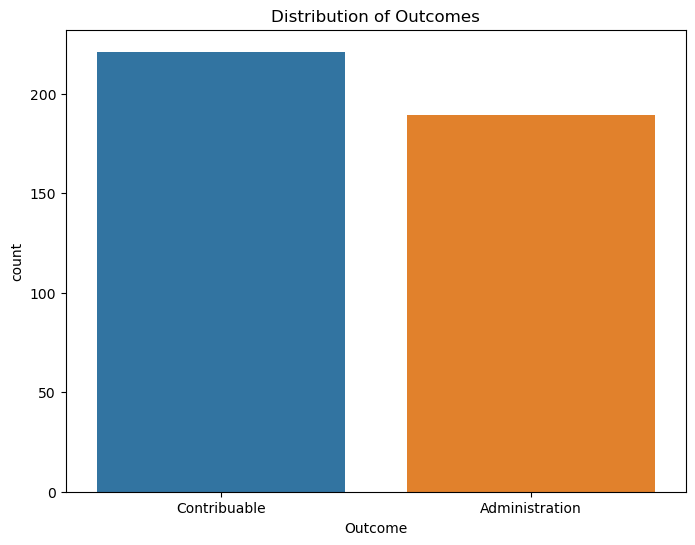

In [235]:
# DF contains only 'Contribuable' and 'Administration' outcomes
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Outcomes')
plt.show()

# We have a close number of Distribuable and Administration, which is good for data analysis


Cross-tabulation:
 Outcome  Administration  Contribuable
Avocat                               
No                   83            37
Yes                 106           184

Chi2 Statistic: 35.03569044770871 
P-value: 3.2371714500784907e-09


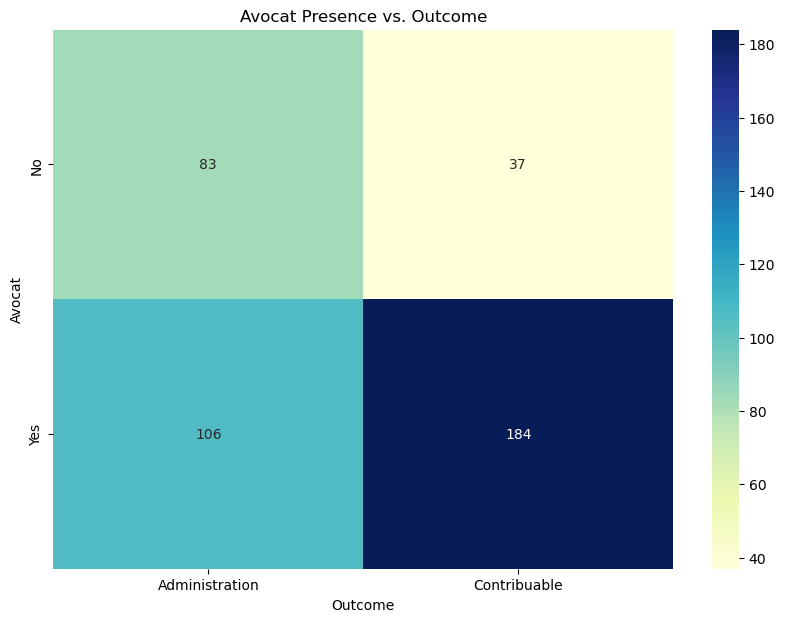

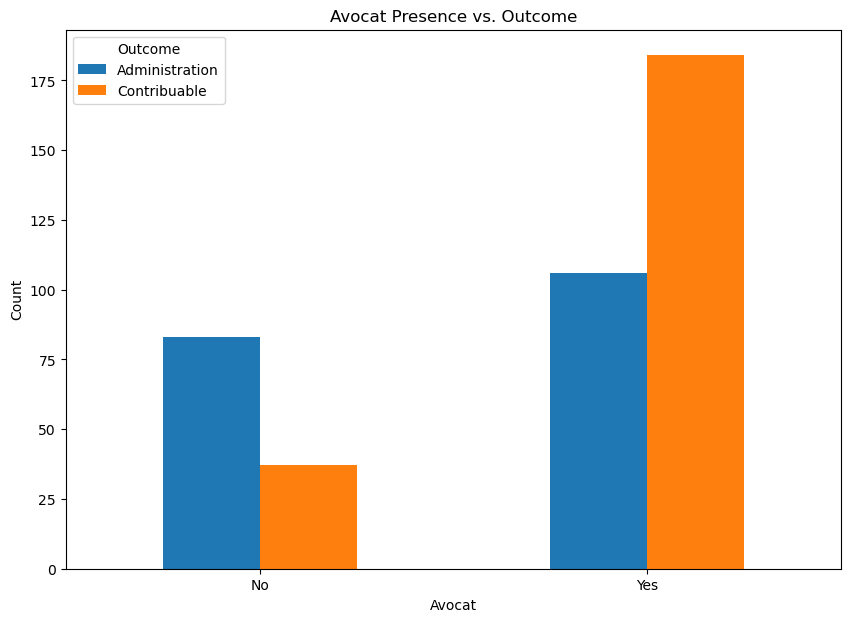

In [237]:
# Perform Chi-Square and cross tabulation to find if having an avocat can inscrease the change of winning
# Creating a cross-tabulation
cross_tab = pd.crosstab(df['Avocat'], df['Outcome'])

# Chi-Square Test
chi2, p_value, dof, expected = chi2_contingency(cross_tab)

# Displaying the cross-tabulation
print("Cross-tabulation:\n", cross_tab)
print("\nChi2 Statistic:", chi2, "\nP-value:", p_value)

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Avocat Presence vs. Outcome')
plt.ylabel('Avocat')
plt.xlabel('Outcome')
plt.show()

# Bar plot for visual comparison
cross_tab.plot(kind='bar', figsize=(10, 7))
plt.title('Avocat Presence vs. Outcome')
plt.ylabel('Count')
plt.xlabel('Avocat')
plt.xticks(rotation=0)
plt.show()

#p-value < 0.05, there is a significant result of the test
#Having an avocat inscrease the chance of winning